In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as obj_lib
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

from scikits.sparse.cholmod import cholesky

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
use_simulated_data = False
if use_simulated_data:
    # Used 2, 5, 10, 20, 40, 60, 100
    num_obs_per_group = 100
    analysis_name = 'simulated_data_for_refit_{}'.format(num_obs_per_group)
    pickle_output_filename = os.path.join(data_dir, '%s_python_refit_jackknife_results.pkl' % analysis_name)
else:
    #analysis_name = 'simulated_data_small'
    analysis_name = 'criteo_subsampled'
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')

vb_data = pickle.load(pkl_file)
model = logit_glmm.load_model_from_pickle(vb_data)
timer = obj_lib.Timer()
kl_hess = obj_lib.unpack_csr_matrix(vb_data['kl_hess_packed'])
moment_jac = vb_data['moment_jac']
moment_wrapper = logit_glmm.MomentWrapper(model.glmm_par)
opt_glmm_free_par = vb_data['glmm_par_free']

In [3]:
def optimize_with_weights(
    model, weights, init_par, preconditioner, gtol=1e-8, print_every=1, verbose=True):

    model.use_weights = True
    model.weights = copy.deepcopy(weights)
    preconditioned_init_par = sp.sparse.linalg.spsolve(preconditioner, init_par)
    return model.tr_optimize_cond(
        preconditioned_init_par,
        preconditioner=preconditioner,
        num_gh_points=model.num_gh_points,
        gtol=gtol,
        print_every=print_every,
        verbose=verbose)   


In [4]:
# Pre-condition with the KL Hessian from the original analysis.
preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
preconditioner = sp.sparse.csr_matrix(preconditioner)

In [5]:
base_weights = np.full(model.x_mat.shape[0], 1.0)
print(np.sum(base_weights))
base_opt = optimize_with_weights(
    model=model,
    preconditioner=preconditioner,
    weights=base_weights,
    init_par=opt_glmm_free_par,
    gtol=1e-8)
base_free_par = model.objective.uncondition_x(base_opt.x)

61895.0
Iter  0  value:  23825.6016424
Iter  1  value:  23825.6016424
         Current function value: 23825.601642
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0


In [6]:
timer.tic()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
timer.toc('moment_jac_time')
moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

moment_jac_time: 7.704058885574341 seconds


In [7]:
# Get a sparse Jacobian.
timer.tic()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=200)
timer.toc('weight_jac_time')
print('Jacobian time: ', timer.time_dict['weight_jac_time'])

Group 0 of 4999
Group 200 of 4999
Group 400 of 4999
Group 600 of 4999
Group 800 of 4999
Group 1000 of 4999
Group 1200 of 4999
Group 1400 of 4999
Group 1600 of 4999
Group 1800 of 4999
Group 2000 of 4999
Group 2200 of 4999
Group 2400 of 4999
Group 2600 of 4999
Group 2800 of 4999
Group 3000 of 4999
Group 3200 of 4999
Group 3400 of 4999
Group 3600 of 4999
Group 3800 of 4999
Group 4000 of 4999
Group 4200 of 4999
Group 4400 of 4999
Group 4600 of 4999
Group 4800 of 4999
weight_jac_time: 61.729551792144775 seconds
Jacobian time:  61.729551792144775


In [8]:
# Get a sparse Hessian.
timer.tic()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=200)
timer.toc('hess_time')
print('Hessian time: ', timer.time_dict['hess_time'])

Group 0 of 4999.
Group 200 of 4999.
Group 400 of 4999.
Group 600 of 4999.
Group 800 of 4999.
Group 1000 of 4999.
Group 1200 of 4999.
Group 1400 of 4999.
Group 1600 of 4999.
Group 1800 of 4999.
Group 2000 of 4999.
Group 2200 of 4999.
Group 2400 of 4999.
Group 2600 of 4999.
Group 2800 of 4999.
Group 3000 of 4999.
Group 3200 of 4999.
Group 3400 of 4999.
Group 3600 of 4999.
Group 3800 of 4999.
Group 4000 of 4999.
Group 4200 of 4999.
Group 4400 of 4999.
Group 4600 of 4999.
Group 4800 of 4999.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


hess_time: 70.28769063949585 seconds
Hessian time:  70.28769063949585


In [15]:
# Invert to get parameter sensitivity.
print('Cholesky...')
timer.tic()
kl_hess_chol = cholesky(kl_hess)
timer.toc('choesky_time')

print('Solving...')
timer.tic()
param_boot_mat = -1 * kl_hess_chol.solve_A(weight_jacobian.T)
timer.toc('inverse_time')

print('Done.')


Cholesky...
choesky_time: 0.01992940902709961 seconds
Solving...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


inverse_time: 11.018663167953491 seconds
Done.


In [23]:
num_obs = model.x_mat.shape[0]
boot_draw = np.random.multinomial(num_obs, [1. / num_obs] * num_obs, size=1)
boot_draw = np.asarray(np.squeeze(boot_draw))
boot_diff_sp = sp.sparse.csc_matrix(boot_draw - 1.0).T

print('Multiply')
timer.tic()
weight_mat = weight_jacobian.T.dot(boot_diff_sp)
timer.toc('weight_jac_mult')

print('Solving with weights...')
timer.tic()
kl_weight_mat = -1 * kl_hess_chol.solve_A(weight_mat)
timer.toc('weight_inverse_time')

Multiply
weight_jac_mult: 0.004601478576660156 seconds
Solving with weights...
weight_inverse_time: 0.0019378662109375 seconds


In [27]:
num_obs = model.x_mat.shape[0]
boot_draw = np.random.multinomial(num_obs, [1. / num_obs] * num_obs, size=1)
boot_draw = np.asarray(np.squeeze(boot_draw))

timer.tic()
boot_diff_sp = sp.sparse.csc_matrix(boot_draw - 1.0).T
timer.toc('Make sparse')

timer.tic()
lr_param_diff = param_boot_mat.dot(boot_diff_sp) 
timer.toc('single lr bootstrap dot')

timer.tic()
lr_param_diff = param_boot_mat * boot_diff_sp
timer.toc('single lr bootstrap')

timer.tic()
lr_param_diff_fast = -1 * kl_hess_chol.solve_A(weight_jacobian.T.dot(boot_diff_sp))
timer.toc('fast bootstrap')

print(sp.sparse.linalg.norm(lr_param_diff_fast - lr_param_diff))


Make sparse: 0.0023086071014404297 seconds
single lr bootstrap dot: 0.7441492080688477 seconds
single lr bootstrap: 0.6968855857849121 seconds
fast bootstrap: 0.002902984619140625 seconds
(10014, 1)
(10014, 1)
1.16983318757e-12


In [13]:
print(param_boot_mat.shape)
print(np.prod(param_boot_mat.shape))
print(param_boot_mat.count_nonzero())

(10014, 61895)
619816530
619816530


In [51]:
def lr_bootstrap(model, param_boot_mat, base_free_par):
    num_obs = model.x_mat.shape[0]
    boot_draw = np.random.multinomial(num_obs, [1. / num_obs] * num_obs, size=1)
    boot_draw = np.asarray(np.squeeze(boot_draw))
    boot_diff_sp = sp.sparse.csc_matrix(boot_draw - 1.0).T
    #lr_param_diff = param_boot_mat * boot_diff_sp
    # The following line is way faster:
    lr_param_diff = -1 * kl_hess_chol.solve_A(weight_jacobian.T.dot(boot_diff_sp))
    glmm_par_lr_boot = base_free_par + np.squeeze(lr_param_diff.toarray())
    return glmm_par_lr_boot, boot_draw

def bootstrap_and_refit(model, preconditioner, param_boot_mat, base_free_par):
    glmm_par_lr_boot, boot_draw = lr_bootstrap(model, param_boot_mat, base_free_par)
    glmm_par_opt_boot = optimize_with_weights(
        model=model,
        preconditioner=preconditioner,
        init_par=glmm_par_lr_boot,
        weights=boot_draw,
        gtol=1e-8,
        verbose=False)
    boot_free_par = model.objective.uncondition_x(glmm_par_opt_boot.x)
    return boot_free_par, glmm_par_opt_boot, glmm_par_lr_boot, boot_draw

In [52]:
timer.tic()
lr_bootstrap(model, param_boot_mat, base_free_par)
timer.toc('lr_bootstrap_single_run_time')

timer.tic()
bootstrap_and_refit(model, preconditioner, param_boot_mat, base_free_par)
timer.toc('full_bootstrap_single_run_time')



(10014,)
lr_bootstrap_single_run_time: 0.015452384948730469 seconds
full_bootstrap_single_run_time: 33.63530898094177 seconds


In [55]:
num_boot_samples = 50
lr_boot_free_par_list = []
boot_free_par_list = []
boot_draw_list = []
timer.tic()
for boot in range(num_boot_samples):
    if boot % 5 == 0:
        print('Bootstrap {} of {}'.format(boot + 1, num_boot_samples))
    boot_free_par, glmm_par_opt_boot, glmm_par_lr_boot, boot_draw = \
        bootstrap_and_refit(model, preconditioner, param_boot_mat, base_free_par)
    boot_free_par_list.append(boot_free_par)
    lr_boot_free_par_list.append(glmm_par_lr_boot)
    boot_draw_list.append(boot_draw)
timer.toc('bootstrap_time')

Bootstrap 1 of 50
Bootstrap 6 of 50
Bootstrap 11 of 50
Bootstrap 16 of 50
Bootstrap 21 of 50
Bootstrap 26 of 50
Bootstrap 31 of 50
Bootstrap 36 of 50
Bootstrap 41 of 50
Bootstrap 46 of 50
bootstrap_time: 1805.2794864177704 seconds


In [54]:
lr_boot_free_par_list_long = []
num_long_boot_samples = 2000
timer.tic()
for boot in range(num_long_boot_samples):
    if boot % 500 == 0:
        print('Bootstrap {} of {}'.format(boot, num_long_boot_samples - 1))
    glmm_par_lr_boot, boot_draw = lr_bootstrap(model, param_boot_mat, base_free_par)
    lr_boot_free_par_list_long.append(glmm_par_lr_boot)
timer.toc('lr_bootstrap_time')


Bootstrap 0 of 1999
Bootstrap 500 of 1999
Bootstrap 1000 of 1999
Bootstrap 1500 of 1999
lr_bootstrap_time: 21.84023118019104 seconds


True param difference: 55.570549286705976
True moment norm difference: 45.03060446125182


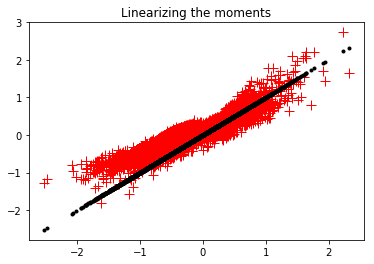

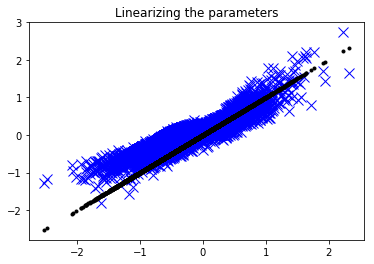

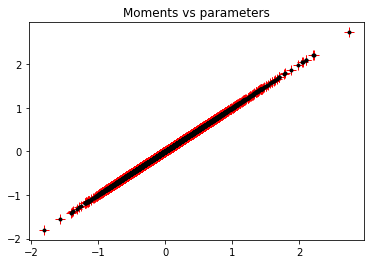

In [56]:
# The actual change in the moment vectors.
boot = 2
boot_free_par = boot_free_par_list[boot]
lr_boot_free_par = lr_boot_free_par_list[boot]

moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)
true_moment_diff = moment_vec_boot - moment_vec
print('True param difference: {}'.format(np.linalg.norm(base_free_par - boot_free_par)))
print('True moment norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

# Use the linear approximation for the parameters, not the moments.
moment_pred_from_params = \
    moment_wrapper.get_moment_vector_from_free(lr_boot_free_par)
moment_pred_from_params_diff = moment_pred_from_params - moment_vec

# The difference based on a linear approximation to the moments.
moment_pred_from_moments_diff = moment_jac_sp * (lr_boot_free_par - base_free_par)

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, moment_pred_from_params_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

# It doesn't make a difference whether you linearize the moments or parameters.
plt.figure()
plt.title('Moments vs parameters')
plt.plot(moment_pred_from_params_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(moment_pred_from_params_diff, moment_pred_from_params_diff, 'k.')
#plt.axis([-10, 10, -10, 10])



In [57]:
# Get the moments in a list form.

lr_boot_moment_vec_list = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in lr_boot_free_par_list ]
lr_boot_moment_vec_list_long = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in lr_boot_free_par_list_long ]
boot_moment_vec_list = \
    [ model.moment_wrapper.get_moment_vector_from_free(par) \
      for par in boot_free_par_list ]
    


In [69]:
# Write the result to a pickle file for use in R.

run_name = 'jackknife'

pickle_result_filename = os.path.join(data_dir, '%s_python_vb_jackknife_results.pkl' % analysis_name)
pickle_output = open(pickle_result_filename, 'wb')

pickle_result_dict = {  'boot_free_par_list': boot_free_par_list,
                        'lr_boot_free_par_list': lr_boot_free_par_list,
                        'lr_boot_free_par_list_long': lr_boot_free_par_list_long,
                        'lr_boot_moment_vec_list': lr_boot_moment_vec_list,
                        'lr_boot_moment_vec_list_long': lr_boot_moment_vec_list_long,
                        'boot_moment_vec_list': boot_moment_vec_list,
                        'boot_draw_list': boot_draw_list,
                        'run_name': run_name,
                        'timer': timer,
                        'base_free_par': base_free_par,
                        'boot_free_par': boot_free_par,
                        'weight_jacobian': obj_lib.pack_csr_matrix(sp.sparse.csr_matrix(weight_jacobian)) }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_result_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/criteo_subsampled_python_vb_jackknife_results.pkl


DONE.
